# model copyed
# [Can you feel my heartbeat?](http://)


> The web app is available at :https://heartfailure-predictor.herokuapp.com/

> Source code: https://github.com/gabbygab1233/Heart-Failure-Predictor-Application/
![](https://i.imgur.com/Yrn231v.png)




In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import plotly.graph_objects as go
import plotly.io as pio
import pickle
from sklearn.utils import resample
# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

# Validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline

# Tuning
from sklearn.model_selection import GridSearchCV

# Feature Extraction
from sklearn.feature_selection import RFE

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder

# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Ensembles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : False})
pio.templates.default = "plotly_white"


df = pd.read_csv('../input/210220/210220.csv')
df.head()

,gender,hypertension,diabete,smokecurrent,hpgrade,chestpain,age,cho,hdl,ldl,...,ps,rccaimt,lccacl,rccact,rccacl,avr_imt,aip,Scorer,Framinghamr,target
0,0,1,0,0,3.0,3,74,2.63,1.60,1.33,...,0.15,0.10,0.00,0.06,0.39,0.10,-0.50,0.10,0.03,0
1,1,0,0,0,3.0,0,69,3.09,0.73,1.86,...,0.17,0.10,0.42,0.00,0.00,0.10,0.39,0.14,0.13,0
2,0,0,0,0,0.5,0,63,6.48,1.65,4.47,...,0.00,0.06,0.00,0.00,0.00,0.06,-0.23,0.03,0.03,0
3,0,1,0,0,3.0,0,63,5.96,1.50,4.59,...,0.71,0.10,0.97,0.58,2.30,0.10,-0.26,0.02,0.05,0
4,1,0,0,1,0.0,0,65,3.73,1.13,2.50,...,0.34,0.10,0.53,0.12,0.62,0.11,-0.03,0.18,0.20,0


In [2]:
# clarify what is y and what is x label
df2 = pd.read_csv('/kaggle/input/210220/210220.csv')

df = df2.drop([ 'hdl', 'ldl', 'crge', 'sbp', 'height', 'nep',
       'ly', 'mo', 'mcvfl', 'glu', 'bun', 'ua', 'ckmb', 'fib', 'dd', 'lccaimt',
       'lccact', 'lccach',   'rccaimt',
       'lccacl', 'rccact', 'rccacl', 'avr_imt', 'aip', 'Scorer', 'Framinghamr'], axis=1)

df.head()

,gender,hypertension,diabete,smokecurrent,hpgrade,chestpain,age,cho,rccach,max_ccach,max_ccacl,ps,target
0,0,1,0,0,3.0,3,74,2.63,0.15,0.15,0.39,0.15,0
1,1,0,0,0,3.0,0,69,3.09,0.00,0.17,0.42,0.17,0
2,0,0,0,0,0.5,0,63,6.48,0.00,0.00,0.00,0.00,0
3,0,1,0,0,3.0,0,63,5.96,0.25,0.25,2.30,0.71,0
4,1,0,0,1,0.0,0,65,3.73,0.19,0.19,0.62,0.34,0


In [3]:
# Analyze Data
def explore_data(df):
    print("Number of Instances and Attributes:", df.shape)
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print('Data types of each columns: ', df.info())
    
# Checking for duplicates
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print("Number of Duplicates: ", count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')
    

# Split training and validation set
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=420)
    return X_train, X_test, y_train, y_test
    
# Spot-Check Algorithms
def GetModel():
    Models = []
    Models.append(('LR'   , LogisticRegression()))
    Models.append(('LDA'  , LinearDiscriminantAnalysis()))
    Models.append(('KNN'  , KNeighborsClassifier()))
    Models.append(('CART' , DecisionTreeClassifier()))
    Models.append(('NB'   , GaussianNB()))
    Models.append(('SVM'  , SVC(probability=True)))
    return Models

def ensemblemodels():
    ensembles = []
    ensembles.append(('AB'   , AdaBoostClassifier()))
    ensembles.append(('GBM'  , GradientBoostingClassifier()))
    ensembles.append(('RF'   , RandomForestClassifier()))
    ensembles.append(( 'Bagging' , BaggingClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    return ensembles

# Spot-Check Normalized Models
def NormalizedModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'normalizer':
        scaler = Normalizer()
    elif nameOfScaler == 'binarizer':
        scaler = Binarizer()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))

    return pipelines


# Train model
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

# Save trained model
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))

# Performance Measure
def classification_metrics(model, conf_matrix):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix for Logisitic Regression Model', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))
    
# ROC_AUC
def roc_auc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8,6))
    print(f"roc_auc score: {auc(fpr, tpr)*100:.1f}%")
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
    plt.legend()
    plt.show()

# [Data Analysis](http://)

In [4]:
explore_data(df)

Number of Instances and Attributes: (1232, 13)


Dataset columns: Index(['gender', 'hypertension', 'diabete', 'smokecurrent', 'hpgrade',
       'chestpain', 'age', 'cho', 'rccach', 'max_ccach', 'max_ccacl', 'ps',
       'target'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        1232 non-null   int64  
 1   hypertension  1232 non-null   int64  
 2   diabete       1232 non-null   int64  
 3   smokecurrent  1232 non-null   int64  
 4   hpgrade       1232 non-null   float64
 5   chestpain     1232 non-null   int64  
 6   age           1232 non-null   int64  
 7   cho           1232 non-null   float64
 8   rccach        1232 non-null   float64
 9   max_ccach     1232 non-null   float64
 10  max_ccacl     1232 non-null   float64
 11  ps            1232 non-null   float64
 12  target        1232 non-null   i

![](https://i.imgur.com/niqOo77.png)

# [ Checking for Nan Values and duplicates](http://)

In [5]:
df.isna().sum()

gender          0
hypertension    0
diabete         0
smokecurrent    0
hpgrade         0
chestpain       0
age             0
cho             0
rccach          0
max_ccach       0
max_ccacl       0
ps              0
target          0
dtype: int64

In [6]:
checking_removing_duplicates(df)

Number of Duplicates:  7
Duplicate values removed!


In [7]:
checking_removing_duplicates(df)

Number of Duplicates:  0
No Duplicate values


In [8]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

gender           1.00
hypertension     1.00
diabete          0.00
smokecurrent     1.00
hpgrade          2.50
chestpain        2.00
age             14.00
cho              1.41
rccach           0.19
max_ccach        0.21
max_ccacl        0.93
ps               0.38
target           1.00
dtype: float64


In [9]:
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out

,gender,hypertension,diabete,smokecurrent,hpgrade,chestpain,age,cho,rccach,max_ccach,max_ccacl,ps,target
0,0,1,0,0,3.0,3,74,2.63,0.15,0.15,0.39,0.15,0
1,1,0,0,0,3.0,0,69,3.09,0.00,0.17,0.42,0.17,0
2,0,0,0,0,0.5,0,63,6.48,0.00,0.00,0.00,0.00,0
3,0,1,0,0,3.0,0,63,5.96,0.25,0.25,2.30,0.71,0
4,1,0,0,1,0.0,0,65,3.73,0.19,0.19,0.62,0.34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1,1,0,1,3.0,0,58,3.39,0.17,0.17,0.46,0.17,1
1226,0,0,0,0,1.0,3,75,3.70,0.28,0.28,1.60,0.53,1
1229,0,1,0,0,2.0,2,75,3.46,0.37,0.37,0.96,0.61,1
1230,1,0,0,0,0.5,3,64,3.92,0.21,0.21,0.82,0.41,1


# [Imbalanced Classes](http://)

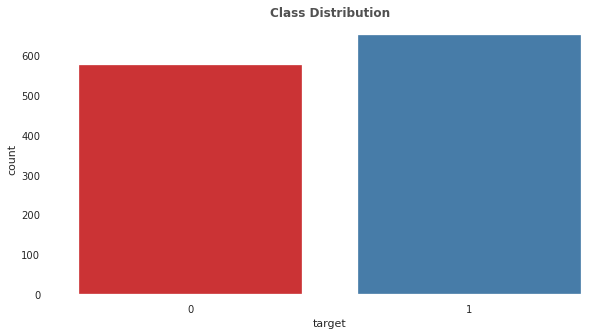

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['target'], palette='Set1');
plt.title('Class Distribution',fontweight="bold",alpha=0.8);

# [Oversample minority class](http://)

In [11]:
cad = df_out[df_out.target == 1]
no_cad = df_out[df_out.target==0]

cad_upsampled = resample(cad,
                        replace=True,
                        n_samples=len(no_cad),
                        random_state=420)

upsampled = pd.concat([no_cad, cad_upsampled])
upsampled.target.value_counts()

0    518
1    518
Name: target, dtype: int64

# [Train model](http://)

In [12]:
target = 'target'
X_train, X_test, y_train, y_test = read_in_and_split_data(upsampled, target)

models = GetModel()
names,results = fit_model(X_train, y_train,models)

LR: 0.701365 (0.048379)
LDA: 0.693640 (0.053916)
KNN: 0.694988 (0.044384)
CART: 0.772061 (0.038261)
NB: 0.693540 (0.055902)
SVM: 0.586846 (0.062810)


# [Improve accuracy using ensemble models](http://)

In [13]:
ensemodel = ensemblemodels()
names,results = fit_model(X_train, y_train,ensemodel)

AB: 0.755345 (0.045270)
GBM: 0.782418 (0.039268)
RF: 0.818548 (0.048469)
Bagging: 0.801815 (0.051053)
ET: 0.826157 (0.039983)


# [Experiment Different preprocessing techniques to improve accuracy](http://)

In [14]:
ScaledModel = NormalizedModel('standard')
name,results = fit_model(X_train, y_train, ScaledModel)

standardLR: 0.697469 (0.051778)
standardLDA: 0.693640 (0.053916)
standardKNN: 0.720713 (0.054836)
standardCART: 0.774742 (0.034825)
standardNB: 0.693540 (0.055902)
standardSVM: 0.707809 (0.031386)
standardAB: 0.755345 (0.045270)
standardGBM: 0.782418 (0.039268)
standardRF: 0.818565 (0.043260)
standardET: 0.822344 (0.039624)


In [15]:
ScaledModel = NormalizedModel('normalizer')
name,results = fit_model(X_train, y_train, ScaledModel)

normalizerLR: 0.629254 (0.086512)
normalizerLDA: 0.709124 (0.042820)
normalizerKNN: 0.754129 (0.032251)
normalizerCART: 0.770946 (0.044559)
normalizerNB: 0.685798 (0.048408)
normalizerSVM: 0.503380 (0.065977)
normalizerAB: 0.745072 (0.055149)
normalizerGBM: 0.781119 (0.055366)
normalizerRF: 0.812005 (0.054020)
normalizerET: 0.827489 (0.042133)


In [16]:
ScaledModel = NormalizedModel('minmax')
name,results = fit_model(X_train, y_train, ScaledModel)

minmaxLR: 0.693640 (0.051015)
minmaxLDA: 0.693640 (0.053916)
minmaxKNN: 0.743823 (0.042817)
minmaxCART: 0.757925 (0.051732)
minmaxNB: 0.693540 (0.055902)
minmaxSVM: 0.715534 (0.027667)
minmaxAB: 0.755345 (0.045270)
minmaxGBM: 0.778571 (0.037177)
minmaxRF: 0.827539 (0.036257)
minmaxET: 0.827489 (0.040167)


# [Fine tuning gradient boosting classifier model](http://)

In [17]:
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
#define grid search

grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
kfold = KFold(n_splits=10, random_state=0)
cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.813387 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0}
0.505794 (0.005328) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.505794 (0.005328) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.517333 (0.037266) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.755428 (0.040724) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.760606 (0.035889) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.746420 (0.026892) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.755411 (0.029342) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
0.763154 (0.035439) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
0.763120 (0.031228) with: {'learning_rate': 0.001, 'm

Training Accuracy Score: 100.0%
Validation Accuracy Score: 81.9%


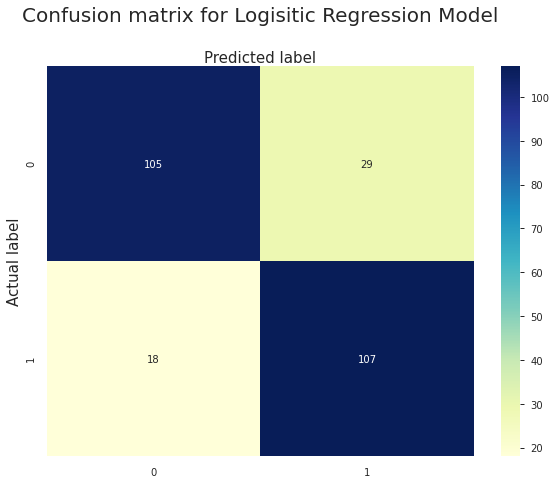

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       134
           1       0.79      0.86      0.82       125

    accuracy                           0.82       259
   macro avg       0.82      0.82      0.82       259
weighted avg       0.82      0.82      0.82       259

roc_auc score: 82.0%


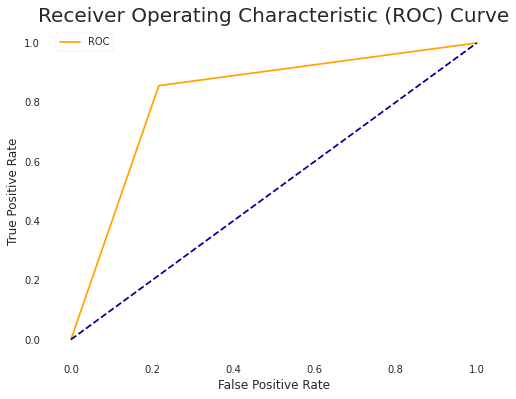

In [18]:
pipeline = make_pipeline(MinMaxScaler(),  GradientBoostingClassifier(learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.7))
model = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)
roc_auc(y_test, y_pred)

save_model(model, 'model.pkl')